<a href="https://colab.research.google.com/github/Ibrahimsyah/Foories/blob/master/notebooks/TF_Learning_with_Confusion%20_matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gdown -q

In [2]:
import pathlib
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm

In [3]:
print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.5.0
• Using TensorFlow Hub Version:  0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
• GPU Device Found.


In [4]:
!gdown 'https://drive.google.com/uc?id=1xGVpcGWblW2xc8WR7LBi5s4rqfNdwQYr' -O dataset_cleaned_v2.zip

Downloading...
From: https://drive.google.com/uc?id=1xGVpcGWblW2xc8WR7LBi5s4rqfNdwQYr
To: /content/dataset_cleaned_v2.zip
170MB [00:03, 54.8MB/s]


In [5]:
!unzip -q dataset_cleaned_v2.zip
!mv /content/content/dataset /content
!rm -rf /content/content

In [6]:
!rm -rf /content/dataset/train/nasirendang
!rm -rf /content/dataset/dev/nasirendang
!rm -rf /content/dataset/test/nasirendang
!rm -rf /content/dataset/train/bread
!rm -rf /content/dataset/dev/bread
!rm -rf /content/dataset/test/bread

In [7]:
dataset_dir = "/content/dataset"
train_dir = "/content/dataset/train"
valid_dir = "/content/dataset/dev"
test_dir = "/content/dataset/test"

In [8]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [9]:
module_selection

('mobilenet_v2', 224, 1280)

In [10]:
BATCH_SIZE = 64 #@param {type:"integer"}

In [11]:
do_fine_tuning = False #@param {type:"boolean"}

In [12]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

In [21]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(14, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 14)                17934     
Total params: 2,275,918
Trainable params: 17,934
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
#@title (Optional) Unfreeze some layers
NUM_LAYERS = 10 #@param {type:"slider", min:1, max:50, step:1}
      
if do_fine_tuning:
    feature_extractor.trainable = True
    
    for layer in model.layers[-NUM_LAYERS:]:
        layer.trainable = True

else:
    feature_extractor.trainable = False

In [23]:
if do_fine_tuning:
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [24]:
# Training datagen
train_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen =  ImageDataGenerator(rescale=1./255)

# Flow training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)

# Flow validation data generator
validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

# Flow test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

Found 10100 images belonging to 14 classes.
Found 1750 images belonging to 14 classes.
Found 1750 images belonging to 14 classes.


In [25]:
class_names = list(train_generator.class_indices.keys())

# Create a labels.txt file with the class names
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

##MobileNet_v2

In [26]:
EPOCHS = 10

hist2 = model.fit(train_generator,
                epochs=EPOCHS,
                validation_data=validation_generator)

Epoch 1/10
158/158 [==============================] - 132s 827ms/step - loss: 1.0825 - accuracy: 0.6773 - val_loss: 0.6528 - val_accuracy: 0.7977
Epoch 2/10
158/158 [==============================] - 130s 820ms/step - loss: 0.6269 - accuracy: 0.8072 - val_loss: 0.5760 - val_accuracy: 0.8286
Epoch 3/10
158/158 [==============================] - 130s 820ms/step - loss: 0.5399 - accuracy: 0.8307 - val_loss: 0.5295 - val_accuracy: 0.8371
Epoch 4/10
158/158 [==============================] - 130s 823ms/step - loss: 0.4937 - accuracy: 0.8480 - val_loss: 0.5231 - val_accuracy: 0.8360
Epoch 5/10
158/158 [==============================] - 131s 828ms/step - loss: 0.4556 - accuracy: 0.8575 - val_loss: 0.4956 - val_accuracy: 0.8491
Epoch 6/10
158/158 [==============================] - 131s 827ms/step - loss: 0.4392 - accuracy: 0.8607 - val_loss: 0.5050 - val_accuracy: 0.8411
Epoch 7/10
158/158 [==============================] - 131s 827ms/step - loss: 0.4075 - accuracy: 0.8732 - val_loss: 0.5098 -

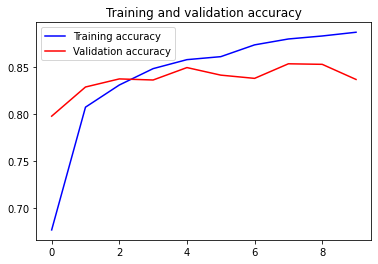

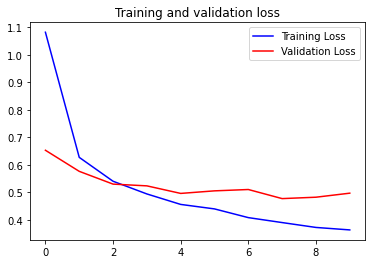

In [27]:
import matplotlib.pyplot as plt
acc = hist2.history['accuracy']
val_acc = hist2.history['val_accuracy']
loss = hist2.history['loss']
val_loss = hist2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [28]:
# Evaluate on Testing data
scores = model.evaluate(test_generator)
print("%s%s: %.2f%%" % ("test acc: ", model.metrics_names[1], scores[1]*100))

28/28 [==============================] - 4s 150ms/step - loss: 0.4504 - accuracy: 0.8520
test acc: accuracy: 85.20%


Conclusion:

Transfer Learning Mobilenet_v2
- Training: 84,34%
- Validation: 80,10%
- Testing: 81,55%

In [ ]:
model.save('model.h5')

##Exporting to TFLite

In [ ]:
# EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format. 
export_dir = 'saved_model/1'

# YOUR CODE HERE
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/1/assets


INFO:tensorflow:Assets written to: saved_model/1/assets


In [ ]:
#@title Select mode of optimization
mode = "Speed" #@param ["Default", "Storage", "Speed"]

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir) # YOUR CODE HERE

# Set the optimzations
converter.optimizations = [optimization] # YOUR CODE HERE

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert() # YOUR CODE HERE

In [ ]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

2647632

In [ ]:
try:
    from google.colab import files
    
    files.download(tflite_model_file)
    files.download('labels.txt')
    files.download('model.h5')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
!gdown https://drive.google.com/uc?id=1vUGcTFykITFUkXsdMu06WIxiCw0iV9ZX -O model.h5

Downloading...
From: https://drive.google.com/uc?id=1vUGcTFykITFUkXsdMu06WIxiCw0iV9ZX
To: /content/model.h5
9.51MB [00:00, 83.4MB/s]


In [57]:
import tensorflow_hub as hub
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [48]:
model = tf.keras.models.load_model('model.h5', custom_objects={'KerasLayer': hub.KerasLayer})

In [58]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=class_names))

Classification Report
              precision    recall  f1-score   support

       bakso       0.73      0.86      0.79       125
       bread       0.83      0.46      0.59       125
     dessert       0.82      0.71      0.76       125
         egg       0.71      0.75      0.73       125
french_fries       0.91      0.86      0.88       125
  fried_rice       0.85      0.86      0.85       125
   hamburger       0.72      0.86      0.78       125
        meat       0.80      0.86      0.83       125
 nasirendang       0.68      0.74      0.71       125
       pizza       0.73      0.90      0.81       125
        sate       0.86      0.86      0.86       125
        soto       0.88      0.76      0.82       125
        soup       0.92      0.94      0.93       125
   spaghetti       0.92      0.98      0.95       125
       sushi       0.88      0.74      0.80       125
    vegfruit       0.91      0.92      0.91       125

    accuracy                           0.82      2000
   m

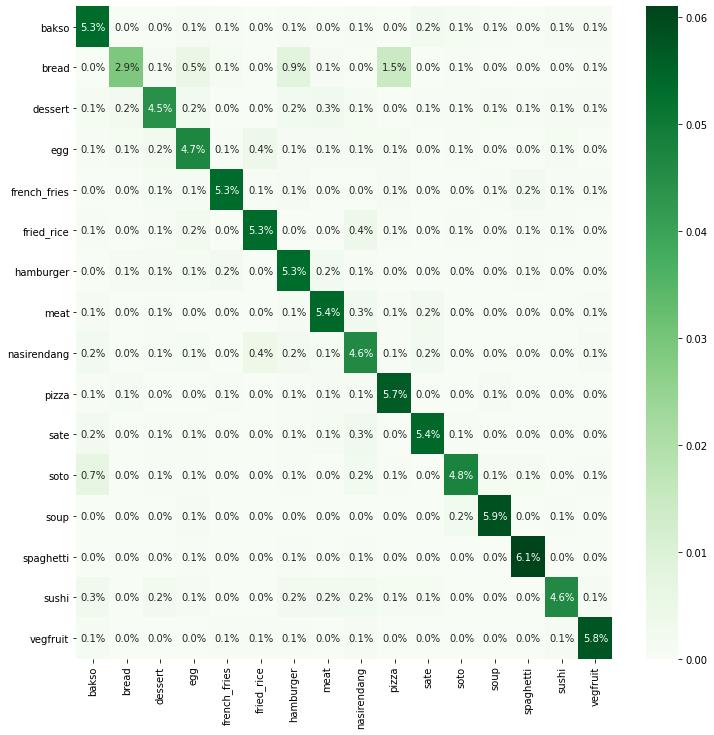

In [70]:
import seaborn as sns
plt.figure(figsize=(12,12))
ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.show()